# Check number of waters near Y501 in rest cache

In [1]:
import mdtraj as md
import numpy as np
import pickle
import os
from tqdm import tqdm_notebook
from simtk.openmm import app
from simtk.openmm import unit
import matplotlib.pyplot as plt
from pymbar import timeseries

In [2]:
def new_positions(hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]
    
def old_positions(hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def make_traj(outdir, htf, i, phase, name, endstate, is_old=True, keep_solvent=False):
    with open(os.path.join(outdir, f"{i}_{phase}_{name}_1ns_snapshots.npy"), "rb") as f:
        cache = np.load(f)
        
#     lengths = np.array([val[i].value_in_unit_system(unit.md_unit_system) for i, val in enumerate(htf.hybrid_system.getDefaultPeriodicBoxVectors())])
#     lengths = np.array([lengths], dtype=np.float64)
#     lengths = np.repeat(lengths, 100, axis=0)

#     angles = np.array([90, 90, 90])
#     angles = np.repeat(np.array([angles]), 100, axis=0)
        
    if is_old:
        old_pos = np.zeros(shape=(100, htf._topology_proposal.old_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            old_pos[j] = old_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))

#         traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology), unitcell_lengths=lengths, unitcell_angles=angles)
    else:
        new_pos = np.zeros(shape=(100, htf._topology_proposal.new_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            new_pos[j] = new_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology))

#         traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology), unitcell_lengths=lengths, unitcell_angles=angles)
      
    # Set unit cell vectors in traj 
    box_vectors = [val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()]
    box_vectors_formatted = np.ndarray(shape=(3,3), buffer=np.array(box_vectors)).astype(np.float32) # note that mdraj expect np.ndarray, not np.arrays
    box_vectors_repeated = np.repeat(np.array([box_vectors_formatted]), traj.xyz.shape[0], axis=0)
    traj.unitcell_vectors = box_vectors_repeated
    
    # Image
    traj.image_molecules(inplace=True)
    
#     if not keep_solvent:
#         traj = traj.remove_solvent(exclude=['Na+', 'Cl-'])
    
    return traj
       

## Y501 complex (15/155)

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/155/"
i = 155
phase = 'complex'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

INFO:rdkit:Enabling RDKit 2021.09.11 jupyter extensions


In [4]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

/scratch/lsftmp/3334142.tmpdir/ipykernel_64690/2759627356.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

In [5]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [6]:
outdir

'/data/chodera/zhangi/perses_benchmark/neq/15/155/'

In [7]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [8]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [9]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

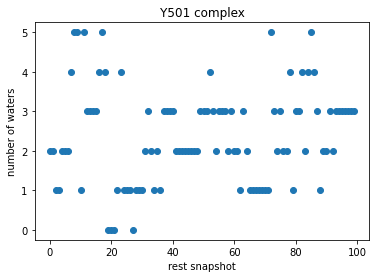

In [10]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 complex")
plt.show()

In [11]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


3.3855137292684616

## Y501 complex (15/156)

In [12]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/156/"
i = 156
phase = 'complex'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [13]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

/scratch/lsftmp/3334142.tmpdir/ipykernel_64690/2759627356.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

In [14]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [15]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [16]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [17]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

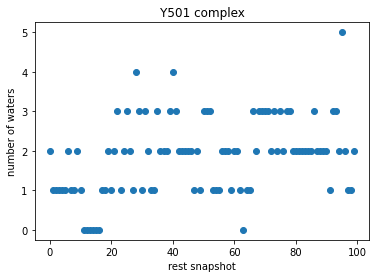

In [18]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 complex")
plt.show()

In [19]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


5.450579787804094

# Check last snapshots of neq switching

In [3]:
def new_positions(hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]
    
def old_positions(hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def make_neq_traj(outdir, htf, i, phase, endstate, is_old=True, keep_solvent=True):
    name = 'old' if is_old else 'new'
    n_atoms = htf.old_positions(htf.hybrid_positions).shape[0] if is_old else htf.new_positions(htf.hybrid_positions).shape[0]
    
#     snapshots = np.zeros((100, n_atoms, 3))
    snapshots = []
    for j in range(100):
        if os.path.isfile(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_{name}_waters.npy")):
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_{name}_waters.npy"), "rb") as f:
                snapshot = np.load(f)
#                 snapshots[j] = snapshot[-1]
                snapshots.append(snapshot[-1])
    snapshots = np.array(snapshots)
    print(f"loaded {snapshots.shape[0]} snapshots")
    print(snapshots.shape)
            
#     lengths = np.array([val[i].value_in_unit_system(unit.md_unit_system) for i, val in enumerate(htf.hybrid_system.getDefaultPeriodicBoxVectors())])
#     lengths = np.array([lengths], dtype=np.float64)
#     lengths = np.repeat(lengths, snapshots.shape[0], axis=0)

#     angles = np.array([90, 90, 90])
#     angles = np.repeat(np.array([angles]), snapshots.shape[0], axis=0)
        
    if is_old:
        traj = md.Trajectory(snapshots, md.Topology.from_openmm(htf._topology_proposal.old_topology))
#         traj = md.Trajectory(snapshots, md.Topology.from_openmm(htf._topology_proposal.old_topology), unitcell_lengths=lengths, unitcell_angles=angles)
    else:
        traj = md.Trajectory(snapshots, md.Topology.from_openmm(htf._topology_proposal.new_topology))
#         traj = md.Trajectory(snapshots, md.Topology.from_openmm(htf._topology_proposal.new_topology), unitcell_lengths=lengths, unitcell_angles=angles)

    # Set unit cell vectors in traj 
    box_vectors = [val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()]
    box_vectors_formatted = np.ndarray(shape=(3,3), buffer=np.array(box_vectors)).astype(np.float32) # note that mdraj expect np.ndarray, not np.arrays
    box_vectors_repeated = np.repeat(np.array([box_vectors_formatted]), traj.xyz.shape[0], axis=0)
    traj.unitcell_vectors = box_vectors_repeated
    
    traj.image_molecules(inplace=True)
    
    if not keep_solvent:
        traj = traj.remove_solvent(exclude=['Na+', 'Cl-'])
    
    return traj
       

##  Y501 15/149

In [4]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/149/"
i = 149
phase = 'complex'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

INFO:rdkit:Enabling RDKit 2021.03.5 jupyter extensions


In [ ]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

loaded 100 snapshots
(100, 185384, 3)


In [ ]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [5]:
pdb = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))
traj = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"), top=pdb)

In [6]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [7]:
water_atoms = traj.topology.select("water and symbol == 'O'")
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

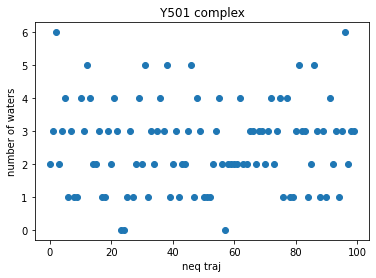

In [8]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 complex")
plt.show()

In [9]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.0

##  Y501 15/150

In [10]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/150/"
i = 150
phase = 'complex'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [ ]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

In [ ]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [11]:
pdb = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))
traj = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"), top=pdb)

In [12]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [13]:
water_atoms = traj.topology.select("water and symbol == 'O'")
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

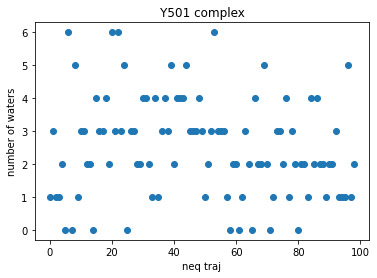

In [14]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 complex")
plt.show()

In [15]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.7261694616063543

In [16]:
for i, num_waters in enumerate(y501_waters):
    if num_waters == 2:
        print(i)

4
12
13
19
28
29
32
40
51
59
60
64
67
68
70
75
79
81
82
85
87
88
90
91
98


In [ ]:
y501_waters[36]

In [ ]:
y501_waters[66]

##  Y501 25/1

In [17]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/25/1/"
i = 1
phase = 'complex'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [ ]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

In [ ]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [18]:
pdb = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))
traj = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"), top=pdb)

In [19]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [20]:
water_atoms = traj.topology.select("water and symbol == 'O'")
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

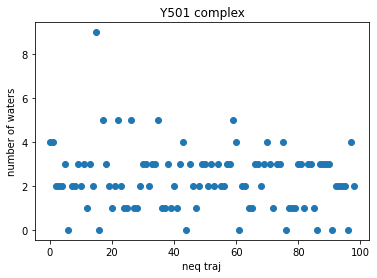

In [21]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 complex")
plt.show()

In [22]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.0

##  Y501 25/2

In [23]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/25/2/"
i = 2
phase = 'complex'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [ ]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

In [ ]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [24]:
pdb = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))
traj = md.load(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"), top=pdb)

In [25]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [26]:
water_atoms = traj.topology.select("water and symbol == 'O'")
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

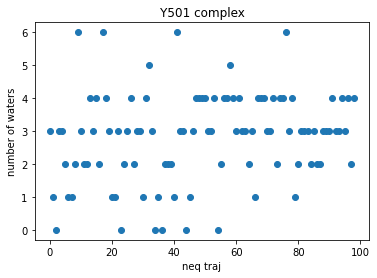

In [27]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 complex")
plt.show()

In [28]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.2479538534126355

In [29]:
for i, num_waters in enumerate(y501_waters):
    if num_waters == 2:
        print(i)

5
8
11
12
16
24
27
37
38
39
55
64
73
80
84
86
87
97


In [35]:
y501_waters[87]

1